# University Certificate in Artificial Intelligence (Hands on AI, Third Challenge, 2022-2023, UMONS)
# Kaggle competition

## Setup

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import os, glob
plt.rcParams['figure.figsize'] = [20, 5]

In [2]:
if not os.path.exists("../work"):
    os.makedirs("../work")

In [3]:
# From Dataframe (HORIZON X SERIES) to Kaggle format (s001h3, ...)
def kaggle_forecasts(fcts):
    submission = fcts.copy()
    submission.index = 1 + np.arange(len(submission))
    submission = submission.stack()
    submission.name = "Forecasts"
    submission = submission.reset_index()

    submission["Id"] = submission["level_1"] + "h" + submission["level_0"].apply(str)
    submission.drop(["level_0", "level_1"], axis=1, inplace=True)
    submission = submission[["Id", "Forecasts"]]
    return submission

## Data loading

In [4]:
DT_train = pd.read_csv("../data/public/train.csv", parse_dates=True)
DT_train["Day"] = pd.to_datetime(DT_train["Day"], format="%Y-%m-%d")
DT_train.set_index("Day", inplace=True)
DT_train = DT_train.asfreq("D")

In [5]:
# Filling missing values
DT_train.fillna(method="backfill", inplace=True)
DT_train.isna().any().any()

False

In [6]:
HORIZON = 7 * 4

<AxesSubplot:xlabel='Day'>

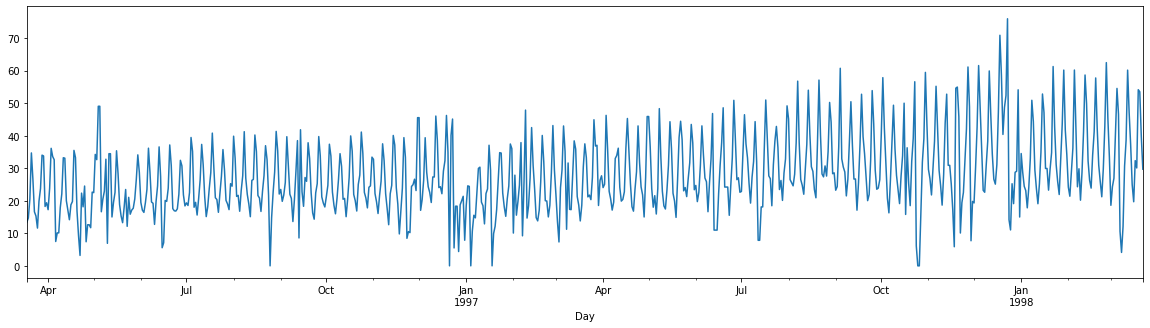

In [27]:
DT_train[list(DT_train.columns)[0]].plot()

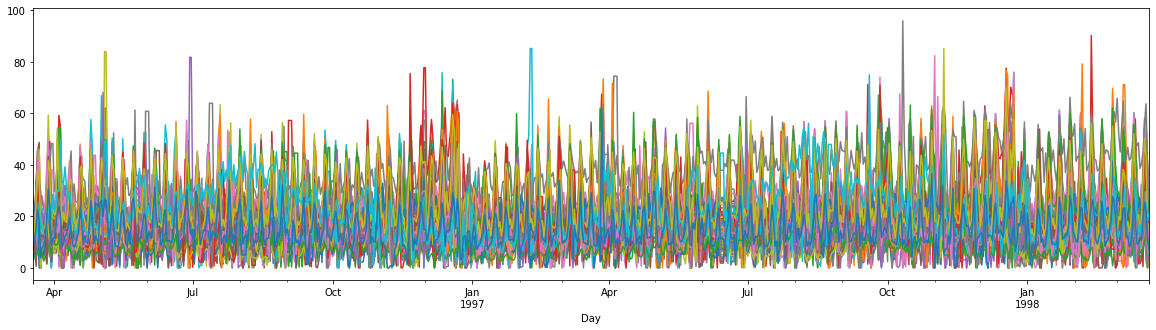

In [30]:

for i in range(len(list(DT_train.columns))):
    DT_train[list(DT_train.columns)[i]].plot()

`forecast_for_kaggle` has to be set to True for the Kaggle competition.
Setting it to False allows to have access to a test dataset using data from `DT_train`.

In [7]:
# Starting dates for validation and test data
valid_start_dt = "1997-09-20"

forecast_for_kaggle = True
if forecast_for_kaggle:
    test_start_dt = "1998-03-23"
else:
    test_start_dt = dt.datetime.strptime("1998-03-23", "%Y-%m-%d") - dt.timedelta(days=HORIZON)
    test_start_dt = test_start_dt.strftime("%Y-%m-%d")
    DT_test = DT_train.tail(HORIZON).copy()
    DT_train = DT_train.head(-HORIZON).copy()

last_day_train = DT_train.index[-1]
test_dates = pd.date_range(start=last_day_train, periods=HORIZON + 1)[1:]

`use_subset_of_series` restricts the number of series to 2 for faster results.

In [8]:
use_subset_of_series = False
if use_subset_of_series:
    id_series_all = DT_train.columns[:2]
else:
    id_series_all = DT_train.columns

## Seasonal naive

In [9]:
"""
period = 7
T = len(DT_train)

fcts_snaive_list = list()

for id_series in id_series_all:
    series_train = DT_train[id_series]
    f_snaive = [series_train[T + h - period * ((HORIZON - 1) // period + 1)] for h in range(0, HORIZON)]
    f_snaive = pd.Series(f_snaive, index=test_dates)
    f_snaive.name = id_series
    fcts_snaive_list.append(f_snaive)

fcts_snaive = pd.concat(fcts_snaive_list, axis=1)

kaggle_submission_naive = kaggle_forecasts(fcts_snaive)
kaggle_submission_naive.to_csv("../work/submission_snaive.csv", index=False)
"""

'\nperiod = 7\nT = len(DT_train)\n\nfcts_snaive_list = list()\n\nfor id_series in id_series_all:\n    series_train = DT_train[id_series]\n    f_snaive = [series_train[T + h - period * ((HORIZON - 1) // period + 1)] for h in range(0, HORIZON)]\n    f_snaive = pd.Series(f_snaive, index=test_dates)\n    f_snaive.name = id_series\n    fcts_snaive_list.append(f_snaive)\n\nfcts_snaive = pd.concat(fcts_snaive_list, axis=1)\n\nkaggle_submission_naive = kaggle_forecasts(fcts_snaive)\nkaggle_submission_naive.to_csv("../work/submission_snaive.csv", index=False)\n'

## AutoArima

In [10]:
"""
from pmdarima.arima import auto_arima

fcts_arima_list = list()

for id_series in id_series_all:
    print("======", id_series, "======")
    y = DT_train[id_series]
    model = auto_arima(
        y,
        d=0,
        start_p=0,
        max_p=5,
        start_q=0,
        max_q=5,
        D=0,
        start_P=0,
        max_P=5,
        start_Q=0,
        max_Q=5,
        m=7,
        trace=False,
    )
    f_arima = model.predict(HORIZON)
    f_arima.name = id_series
    fcts_arima_list.append(f_arima)

fcts_arima = pd.concat(fcts_arima_list, axis=1)

kaggle_submission_arima = kaggle_forecasts(fcts_arima)
kaggle_submission_arima.to_csv("../work/submission_arima.csv", index=False)
"""

'\nfrom pmdarima.arima import auto_arima\n\nfcts_arima_list = list()\n\nfor id_series in id_series_all:\n    print("======", id_series, "======")\n    y = DT_train[id_series]\n    model = auto_arima(\n        y,\n        d=0,\n        start_p=0,\n        max_p=5,\n        start_q=0,\n        max_q=5,\n        D=0,\n        start_P=0,\n        max_P=5,\n        start_Q=0,\n        max_Q=5,\n        m=7,\n        trace=False,\n    )\n    f_arima = model.predict(HORIZON)\n    f_arima.name = id_series\n    fcts_arima_list.append(f_arima)\n\nfcts_arima = pd.concat(fcts_arima_list, axis=1)\n\nkaggle_submission_arima = kaggle_forecasts(fcts_arima)\nkaggle_submission_arima.to_csv("../work/submission_arima.csv", index=False)\n'

In [11]:
from main.utils.utils_methods import embed_data, plot_learning_curves

import keras
from keras.models import Sequential
from keras.layers import (
    Dense,
    GRU,
    SimpleRNN,
    LSTM,
    Conv1D,
    Flatten,
    RepeatVector,
    TimeDistributed,
    Flatten,
    Input,
)
from keras.callbacks import EarlyStopping, ModelCheckpoint

## Multilayer Perceptron (MLP)

In [12]:
def mlp(X_train, y_train, X_valid, y_valid, best_val, **kwargs):
    model = Sequential()
    model.add(Dense(kwargs["LATENT_DIM"], activation="relu", input_shape=(kwargs["LAG"],)))
    model.add(Dense(kwargs["output_size"]))

    model.compile(optimizer=kwargs["optimizer"], loss=kwargs["loss"])

    history = model.fit(
        X_train,
        y_train,
        batch_size=kwargs["BATCH_SIZE"],
        epochs=kwargs["EPOCHS"],
        validation_data=(X_valid, y_valid),
        callbacks=[kwargs["earlystop"], best_val],
        verbose=kwargs["verbose"],
    )
    return model, history

## 1-D Convolutional Neural Networks (CNN)


In [13]:
def cnn_dilated(train_inputs, valid_inputs, best_val, **kwargs):
    model = Sequential()
    model.add(
        Conv1D(
            kwargs["LATENT_DIM"],
            kernel_size=kwargs["KERNEL_SIZE"],
            padding="causal",
            strides=1,
            activation="relu",
            dilation_rate=1,
            input_shape=(kwargs["LAG"], 1),
        )
    )
    model.add(
        Conv1D(
            kwargs["LATENT_DIM"],
            kernel_size=kwargs["KERNEL_SIZE"],
            padding="causal",
            strides=1,
            activation="relu",
            dilation_rate=2,
        )
    )
    model.add(
        Conv1D(
            kwargs["LATENT_DIM"],
            kernel_size=kwargs["KERNEL_SIZE"],
            padding="causal",
            strides=1,
            activation="relu",
            dilation_rate=4,
        )
    )
    model.add(Flatten())
    model.add(Dense(kwargs["output_size"], activation="linear"))

    model.compile(optimizer=kwargs["optimizer"], loss=kwargs["loss"])
    history = model.fit(
        train_inputs["encoder_input"],
        train_inputs["target"],
        batch_size=kwargs["BATCH_SIZE"],
        epochs=kwargs["EPOCHS"],
        validation_data=(valid_inputs["encoder_input"], valid_inputs["target"]),
        callbacks=[kwargs["earlystop"], best_val],
        verbose=kwargs["verbose"],
    )
    return model, history

## RNN vector-output


In [14]:
def rnn_vector_output(train_inputs, valid_inputs, best_val, **kwargs):
    model = Sequential()
    model.add(kwargs["RECURRENT_MODEL"](kwargs["LATENT_DIM"], input_shape=(kwargs["LAG"], 1)))
    model.add(Dense(kwargs["output_size"]))

    model.compile(optimizer=kwargs["optimizer"], loss=kwargs["loss"])

    history = model.fit(
        train_inputs["encoder_input"],
        train_inputs["target"],
        batch_size=kwargs["BATCH_SIZE"],
        epochs=kwargs["EPOCHS"],
        validation_data=(valid_inputs["encoder_input"], valid_inputs["target"]),
        callbacks=[kwargs["earlystop"], best_val],
        verbose=kwargs["verbose"],
    )
    return model, history

## RNN encoder-decoder



In [15]:
def rnn_encoder_decoder(train_inputs, valid_inputs, best_val, **kwargs):
    model = Sequential()
    model.add(kwargs["RECURRENT_MODEL"](kwargs["LATENT_DIM"], input_shape=(kwargs["LAG"], 1)))
    model.add(RepeatVector(kwargs["output_size"]))
    model.add(kwargs["RECURRENT_MODEL"](kwargs["LATENT_DIM"], return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())

    model.compile(optimizer=kwargs["optimizer"], loss=kwargs["loss"])

    history = model.fit(
        train_inputs["encoder_input"],
        train_inputs["target"],
        batch_size=kwargs["BATCH_SIZE"],
        epochs=kwargs["EPOCHS"],
        validation_data=(valid_inputs["encoder_input"], valid_inputs["target"]),
        callbacks=[kwargs["earlystop"], best_val],
        verbose=kwargs["verbose"],
    )
    return model, history

## Data transformation

In [16]:
log_transformation = True
clean_series = True

from statsmodels.tsa.seasonal import STL

for id_series in id_series_all:
    print("======", id_series, "======")

    # Log transformation
    if log_transformation:
        series = DT_train[id_series]
        series = np.log1p(series)
        DT_train[id_series] = series

    if clean_series:
        # Replace zeroes
        series = DT_train[id_series]
        series[series == 0] = pd.NA
        series.replace(0, value=pd.NA, inplace=True)
        series.fillna(method="backfill", inplace=True)
        # Season-Trend decomposition using LOESS
        stl = STL(series, period=7, robust=True, seasonal=7 * 50 + 1, trend=7 * 50 + 1)
        result = stl.fit()
        # Remove outliers in the residuals
        e = result.resid.copy()
        q_l, q_u = np.quantile(e, [0.05, 0.95])
        e[e <= q_l] = pd.NA
        e[e >= q_u] = pd.NA
        e.fillna(method="backfill", inplace=True)
        series = result.trend + result.seasonal + e

        DT_train[id_series] = series

====== s001 ======
====== s002 ======
====== s003 ======
====== s004 ======
====== s005 ======
====== s006 ======
====== s007 ======
====== s008 ======
====== s009 ======
====== s010 ======
====== s011 ======
====== s012 ======
====== s013 ======
====== s014 ======
====== s015 ======
====== s016 ======
====== s017 ======
====== s018 ======
====== s019 ======
====== s020 ======
====== s021 ======
====== s022 ======
====== s023 ======
====== s024 ======
====== s025 ======
====== s026 ======
====== s027 ======
====== s028 ======
====== s029 ======
====== s030 ======
====== s031 ======
====== s032 ======
====== s033 ======
====== s034 ======
====== s035 ======
====== s036 ======
====== s037 ======
====== s038 ======
====== s039 ======
====== s040 ======
====== s041 ======
====== s042 ======
====== s043 ======
====== s044 ======
====== s045 ======
====== s046 ======
====== s047 ======
====== s048 ======
====== s049 ======
====== s050 ======
====== s051 ======
====== s052 ======
====== s053 

## Forecast decomposition

* Do we forecast the raw series? If not, we first decompose the series into trend, seasonal and remainder components. Then, we forecast each components independently. Alternatively, we can combine the trend and remainder components.

In [17]:
forecast_by_decomposition = False
combine_trend_and_remainder = False

if forecast_by_decomposition:
    fcts_trend_list = list()
    fcts_seas_list = list()
    for id_series in id_series_all:
        print("======", id_series, "======")
        series = DT_train[id_series]
        stl = STL(series, period=7, robust=True, seasonal=7 * 50 + 1, trend=7 * 50 + 1)
        result = stl.fit()
        if use_subset_of_series:
            result.plot()
            plt.show()

        trend_component = result.trend
        seasonal_component = result.seasonal
        remainder_component = result.resid

        if not combine_trend_and_remainder:
            # Forecast the trend
            from statsmodels.tsa.api import SimpleExpSmoothing

            fit_ses = SimpleExpSmoothing(trend_component, initialization_method="estimated").fit()
            pred_trend = fit_ses.forecast(HORIZON)
            fcts_trend_list.append(pred_trend)

            # Remainder
            DT_train[id_series] = remainder_component
        else:
            DT_train[id_series] = trend_component + remainder_component

        # Forecast the seasonality
        pred_seasonal = seasonal_component.tail(HORIZON)
        fcts_seas_list.append(pred_seasonal)

    if not combine_trend_and_remainder:
        fcts_trend = pd.concat(fcts_trend_list, axis=1)
        fcts_trend.columns = id_series_all

    fcts_seas = pd.concat(fcts_seas_list, axis=1)
    fcts_seas.columns = id_series_all
    fcts_seas.index = test_dates

In [18]:
# Add rows to easily build X_test.

DT_train.shape[1]

DT_pad = DT_train.tail(HORIZON).copy()
DT_pad.index = test_dates
DT_pad[:] = np.inf
DT = pd.concat([DT_train, DT_pad])

## Hyperparameter configuration


In [19]:
optimizer_adam = keras.optimizers.Adam(learning_rate=0.01)  # optimizer_rmsprop = 'RMSprop'
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=50, restore_best_weights=True)
verbose = 0

# Loss function to be used to optimize the model parameters
loss_fct = "mae"  # 'mae'

LAG = 8  # 4
params_mlp_rec = {
    "LATENT_DIM": 5,
    "BATCH_SIZE": 32,
    "EPOCHS": 10,
    "LAG": LAG,
    "output_size": 1,
    "loss": loss_fct,
    "optimizer": optimizer_adam,
    "earlystop": earlystop,
    "verbose": verbose,
}
params_mlp_mo = {
    "LATENT_DIM": 5,
    "BATCH_SIZE": 32,
    "EPOCHS": 100,
    "LAG": LAG,
    "output_size": HORIZON,
    "loss": loss_fct,
    "optimizer": optimizer_adam,
    "earlystop": earlystop,
    "verbose": verbose,
}
params_cnn = {
    "KERNEL_SIZE": 10,
    "LATENT_DIM": 5,
    "BATCH_SIZE": 32,
    "EPOCHS": 10,
    "LAG": LAG,
    "output_size": HORIZON,
    "loss": loss_fct,
    "optimizer": optimizer_adam,
    "earlystop": earlystop,
    "verbose": verbose,
}
params_rnn = {
    "RECURRENT_MODEL": GRU,
    "LATENT_DIM": 5,
    "BATCH_SIZE": 32,
    "EPOCHS": 100,
    "LAG": LAG,
    "output_size": HORIZON,
    "loss": loss_fct,
    "optimizer": optimizer_adam,
    "earlystop": earlystop,
    "verbose": verbose,
}
# RECURRENT_MODEL:  SimpleRNN or GRU or LSTM

## Model training and forecasting


In [20]:
enable_plots = False

methods = ["mlp_recursive"]
#methods = ["mlp_recursive", "mlp_multioutput", "cnn", "rnn_vector_output", "rnn_encoder_decoder"]

forecasts_lists = {
    method: []
    for method in methods
}

# Useful to build X_valid and X_test
look_back_valid = dt.datetime.strptime(valid_start_dt, "%Y-%m-%d") - dt.timedelta(days=LAG)
look_back_test = dt.datetime.strptime(test_start_dt, "%Y-%m-%d") - dt.timedelta(days=LAG)

for id_series in id_series_all:
    print(id_series)

    ##TRAINING/VALIDATION/TEST DATA
    train = DT.copy()[DT.index < valid_start_dt][[id_series]]
    valid = DT.copy()[(DT.index >= look_back_valid) & (DT.index < test_start_dt)][[id_series]]
    test = DT.copy()[(DT.index >= look_back_test)][[id_series]]
    train_inputs, valid_inputs, test_inputs, X_train, y_train, X_valid, y_valid, X_test, y_test = embed_data(
        train, valid, test, HORIZON, LAG, variable=id_series
    )

    for method in methods:
        file_header = "model_" + method + "_" + id_series
        best_val = ModelCheckpoint(
            "../work/" + file_header + "_{epoch:02d}.h5",
            save_best_only=True,
            mode="min",
            save_freq="epoch",
            monitor="val_loss",
        )
        if method == "mlp_recursive":
            _, _, _, X_train_onestep, y_train_onestep, X_valid_onestep, y_valid_onestep, _, _ = embed_data(
                train, valid, test, 1, LAG, freq=None, variable=id_series
            )
            model, history_loss = mlp(
                X_train_onestep,
                y_train_onestep,
                X_valid_onestep,
                y_valid_onestep,
                best_val=best_val,
                **params_mlp_rec
            )
        elif method == "mlp_multioutput":
            model, history_loss = mlp(X_train, y_train, X_valid, y_valid, best_val=best_val, **params_mlp_mo)
        elif method == "cnn":
            model, history_loss = cnn_dilated(train_inputs, valid_inputs, best_val=best_val, **params_cnn)
        elif method == "rnn_vector_output":
            model, history_loss = rnn_vector_output(
                train_inputs, valid_inputs, best_val=best_val, **params_rnn
            )
        elif method == "rnn_encoder_decoder":
            model, history_loss = rnn_encoder_decoder(
                train_inputs, valid_inputs, best_val=best_val, **params_rnn
            )

        if enable_plots:
            plot_learning_curves(history_loss, title=id_series + " - " + method)

        best_epoch = np.argmin(np.array(history_loss.history["val_loss"])) + 1
        filepath = "../work/" + file_header + "_{:02d}.h5"
        model.load_weights(filepath.format(best_epoch))

        # Delete files (generate too many files)
        for filename in glob.glob("../work/*" + file_header + "*"):
            os.remove(filename)

        ## Forecasting
        if method == "mlp_recursive":
            for h in range(HORIZON):
                pred = model.predict(X_test, verbose=0)
                X_test = pd.DataFrame(
                    np.hstack((np.delete(X_test.to_numpy(), 0, 1), pred)),
                    index=X_test.index,
                    columns=X_test.columns,
                )
                if h > 0:
                    predictions = np.hstack((predictions, pred))
                else:
                    predictions = pred
            forecasts_lists[method].append(pd.DataFrame(predictions).T)
        elif method == "mlp_multioutput":
            predictions = model.predict(X_test, verbose=0)
            forecasts_lists[method].append(pd.DataFrame(predictions).T)
        elif method in ["cnn", "rnn_vector_output", "rnn_encoder_decoder"]:
            predictions = model.predict(test_inputs["encoder_input"], verbose=0)
            if method == "cnn":
                forecasts_lists[method].append(pd.DataFrame(predictions).T)
            elif method == "rnn_vector_output":
                forecasts_lists[method].append(pd.DataFrame(predictions).T)
            elif method == "rnn_encoder_decoder":
                forecasts_lists[method].append(pd.DataFrame(predictions).T)

s001
s002
s003
s004
s005
s006
s007
s008
s009
s010
s011
s012
s013
s014
s015
s016
s017
s018
s019
s020
s021


ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [ ]:
def make_forecast_from_list(forecast_list):
    forecast = pd.concat(forecast_list, axis=1)
    forecast.columns = id_series_all
    forecast.index = test_dates
    return forecast

forecasts = {
    method: make_forecast_from_list(forecasts_list)
    for method, forecasts_list in forecasts_lists.items()
}

## Inverse data transformation and decomposition

In [ ]:
def inverse_transform(fct):
    if forecast_by_decomposition:
        fct += fcts_seas
        if not combine_trend_and_remainder:
            fct += fcts_trend
    if log_transformation:
        fct = np.expm1(fct)
    return fct

forecasts = {
    method: inverse_transform(fct)
    for method, fct in forecasts.items()
}

In [ ]:
fcts_zero = pd.DataFrame(0, index=fcts_seas.index, columns=fcts_seas.columns)
fcts_zero = inverse_transform(fcts_zero)

In [ ]:
def smape(y_true, y_pred):
    assert (y_pred >= 0).all().all()
    denominator = (y_true + y_pred) / 200.0
    SAPE = np.abs(y_true - y_pred) / denominator
    SAPE[denominator == 0] = 0.0
    return SAPE.mean().mean()

In [ ]:
for method, fcts in forecasts.items():
    kaggle_submission = kaggle_forecasts(fcts)
    kaggle_submission.to_csv(f"../work/submission_{method}.csv", index=False)

## Test procedure

In [ ]:
kaggle_test_available = os.path.exists("../data/private")

if forecast_for_kaggle and kaggle_test_available:
    print("Reading file")
    DT_test = pd.read_csv("../data/private/test.csv", parse_dates=True)
    DT_test["Day"] = pd.to_datetime(DT_test["Day"], format="%Y-%m-%d")
    DT_test.set_index("Day", inplace=True)
    DT_test = DT_test.asfreq("D")
    DT_test.head()

if not forecast_for_kaggle or kaggle_test_available:
    DT_test_sub = DT_test[id_series_all]
    print(smape(DT_test_sub, fcts_snaive))
    print(smape(DT_test_sub, fcts_arima))

    for method, fcts in forecasts.items():
        print(smape(DT_test_sub, fcts))

    DT_test_sub["s001"].plot()
    fcts_snaive["s001"].plot()